In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
project_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression'

# # 10 images 0 to 9 - 1 each
# img_path = project_path + r'\\Data\Data-10-images'
# model_name = 'nn-10-0to9.h5'
# grayscale_path = img_path + '-gray'

# # 10 images of 1
# img_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression\Data\Data-10-images-1'
# model_name = 'nn-10-1.h5'
# grayscale_path = img_path + '-gray'

# # All images of 1 - 10772 images
# img_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression\Data\dataset\1\1'
# model_name = 'nn-all-1.h5'
# grayscale_path = img_path + '-gray'

# All images 0 to 9 - 118503 images
img_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression\Data\Data-all-images'
model_name = 'nn-all.h5'
grayscale_path = img_path + '-gray'


model_save_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression'

# Create the folder if it doesn't exist
if not os.path.exists(grayscale_path):
    os.makedirs(grayscale_path)

image_extension = '.png'

data = []

# Loop through all directories and subdirectories
for root, dirs, files in os.walk(img_path):
    for file in files:
        if file.lower().endswith(image_extension):
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                
                # If the image is in RGBA, convert transparent pixels to white
                if img.mode == 'RGBA':
                    white_bg = Image.new('RGB', img.size, (255, 255, 255))
                    white_bg.paste(img, mask=img.split()[3])
                    # Convert the image to grayscale (L mode)
                    img = white_bg.convert('L')
                else:
                    # If the image is already grayscale or RGB, just convert it to grayscale
                    img = img.convert('L')
                
                # Convert image to numpy array and save to DataFrame
                img_data = np.array(img)
                label = file_path.split('\\')[-1]
                data.append({"label": label, "image_data": img_data})

                # Save the converted grayscale image
                save_path = os.path.join(grayscale_path, file)
                img.save(save_path)

            except Exception as e:
                print(f"Error opening {file_path}: {e}")

# Create a DataFrame
df = pd.DataFrame(data)
print(df.head())

        label                                         image_data
0     0_0.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1     0_1.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
2    0_10.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
3   0_100.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
4  0_1000.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...


In [3]:
# Extract labels from the dataframe
labels = df['label'].values

# Convert the labels to integer encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

In [4]:
# Assuming all images are grayscale and of size
X = df['image_data'].values

# Normalize pixel values
X = np.array([x.flatten() / 255.0 for x in X])  # Flatten the images and normalize pixel values

In [26]:
# Define the model with an Embedding layer
def create_model(num_labels, output_dim, embedding_dim):
    model = models.Sequential()
    # Embedding layer: Takes integer-encoded labels and maps to dense vectors (embeddings)
    model.add(layers.Embedding(input_dim=num_labels, output_dim=embedding_dim, input_length=1))
    # Flatten the embedding output to pass to the next layer
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())  # Optional: normalize activations
    model.add(layers.Dense(32, activation='relu'))      
    # Output layer (flattened image)
    model.add(layers.Dense(output_dim, activation='sigmoid'))  # Output should be flattened to match image size
    
    return model

# integer_encoded has shape (num_samples,)
num_labels = len(np.unique(integer_encoded))  # Total number of unique labels
output_dim = 28 * 28
# Set embedding size to the square root of the number of labels
# embedding_dim = max(2, int(np.sqrt(num_labels) / 10))
embedding_dim = max(2, int((num_labels)**(1/5)))


# Create the model
model = create_model(num_labels, output_dim, embedding_dim)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1, 10)             1185030   
                                                                 
 flatten_5 (Flatten)         (None, 10)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                352       
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 784)               25872     
                                                      

In [27]:
# Train the model
model.fit(integer_encoded, X, epochs=200, batch_size=64)

Epoch 1/200
1852/1852 [==============================] - 19s 10ms/step - loss: 0.0524 - accuracy: 8.4386e-06
Epoch 2/200
1852/1852 [==============================] - 17s 9ms/step - loss: 0.0464 - accuracy: 1.6877e-05
Epoch 3/200
1852/1852 [==============================] - 17s 9ms/step - loss: 0.0426 - accuracy: 2.5316e-05
Epoch 4/200
1852/1852 [==============================] - 22s 12ms/step - loss: 0.0381 - accuracy: 7.5947e-05
Epoch 5/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0346 - accuracy: 7.7635e-04
Epoch 6/200
1852/1852 [==============================] - 17s 9ms/step - loss: 0.0321 - accuracy: 0.0071
Epoch 7/200
1852/1852 [==============================] - 18s 9ms/step - loss: 0.0302 - accuracy: 0.0216
Epoch 8/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0287 - accuracy: 0.0406
Epoch 9/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0276 - accuracy: 0.0650
Epoch 10/200
1852/1852 [===============

1852/1852 [==============================] - 17s 9ms/step - loss: 0.0178 - accuracy: 0.2366
Epoch 79/200
1852/1852 [==============================] - 19s 10ms/step - loss: 0.0177 - accuracy: 0.2361
Epoch 80/200
1852/1852 [==============================] - 19s 10ms/step - loss: 0.0177 - accuracy: 0.2341
Epoch 81/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0177 - accuracy: 0.2360
Epoch 82/200
1852/1852 [==============================] - 17s 9ms/step - loss: 0.0177 - accuracy: 0.2326
Epoch 83/200
1852/1852 [==============================] - 17s 9ms/step - loss: 0.0177 - accuracy: 0.2285
Epoch 84/200
1852/1852 [==============================] - 18s 9ms/step - loss: 0.0176 - accuracy: 0.2272
Epoch 85/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0176 - accuracy: 0.2274
Epoch 86/200
1852/1852 [==============================] - 19s 10ms/step - loss: 0.0176 - accuracy: 0.2262
Epoch 87/200
1852/1852 [==============================] - 19s 1

Epoch 155/200
1852/1852 [==============================] - 20s 11ms/step - loss: 0.0167 - accuracy: 0.1654
Epoch 156/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0167 - accuracy: 0.1678
Epoch 157/200
1852/1852 [==============================] - 19s 10ms/step - loss: 0.0167 - accuracy: 0.1637
Epoch 158/200
1852/1852 [==============================] - 20s 11ms/step - loss: 0.0167 - accuracy: 0.1632
Epoch 159/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0167 - accuracy: 0.1637
Epoch 160/200
1852/1852 [==============================] - 18s 9ms/step - loss: 0.0167 - accuracy: 0.1626
Epoch 161/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0167 - accuracy: 0.1631
Epoch 162/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0167 - accuracy: 0.1606
Epoch 163/200
1852/1852 [==============================] - 18s 10ms/step - loss: 0.0167 - accuracy: 0.1599
Epoch 164/200
1852/1852 [=============

In [34]:
model.save_weights(model_save_path + '\\saved_embedded_weights\\' + model_name) # save weights only

# Save the architecture
model_json = model.to_json()
with open(model_save_path + '\\saved_architecture\\embeddings_weights', "w") as json_file:
    json_file.write(model_json)

In [29]:
# model = tf.keras.models.load_model('\\nn-10-1.h5')

# Load the architecture from the file
from keras.models import model_from_json
with open(model_save_path + '\\saved_architecture\\embeddings_weights', "r") as json_file:
    loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    
# Load the weights into the new model
model.load_weights(model_save_path + '\\saved_embedded_weights\\' + model_name)

In [30]:
# Compile the model (necessary if you're going to use it for training or evaluation)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1, 10)             1185030   
                                                                 
 flatten_5 (Flatten)         (None, 10)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                352       
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 784)               25872     
                                                      

In [32]:
def pixel_accuracy(original, predicted):
    """
    Calculate pixel accuracy based on the mean absolute error between the original and predicted images.

    Parameters:
    original (np.array): The original image array (shape: height x width).
    predicted (np.array): The predicted image array (shape: height x width).

    Returns:
    float: The pixel accuracy as a percentage.
    """
    original = np.array(original)
    predicted = np.array(predicted)
    
    # Check if the shapes match
    if original.shape != predicted.shape:
        raise ValueError("Original and predicted images must have the same shape.")
    
    # Calculate the mean absolute error
    mae = np.mean(np.abs(original - predicted))

    # Convert MAE to a percentage accuracy (assuming pixel values are in [0, 255])
    max_mae = 255
    accuracy = 100 * (1 - (mae / max_mae))  # Normalize accuracy to be between 0 and 100

    return accuracy  # Return as percentage

# Function to get the original image data from the DataFrame
def get_original_image_from_df(label, df):
    # Locate the row in the DataFrame that matches the label
    row = df[df['label'] == label]
    if not row.empty:
        return row['image_data'].values[0]  # Get the image data
    else:
        print("Label not found in DataFrame.")
        return None

1/1 [==============================] - 0s 62ms/step
Pixel Accuracy for label '1-gray_8761.png': 99.05%


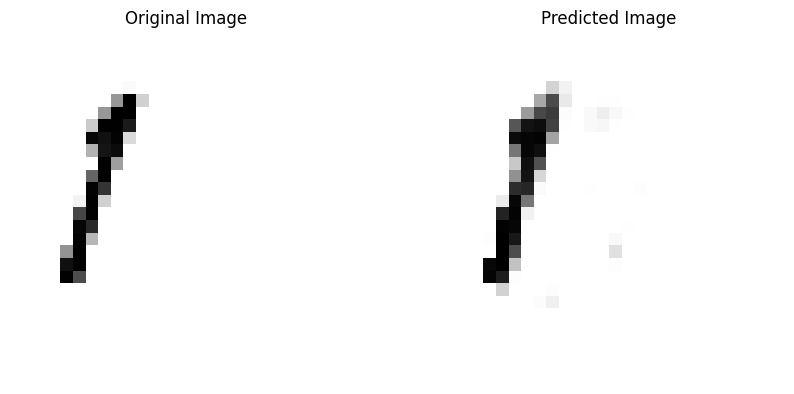

1/1 [==============================] - 0s 15ms/step
Pixel Accuracy for label '7_5854.png': 97.60%


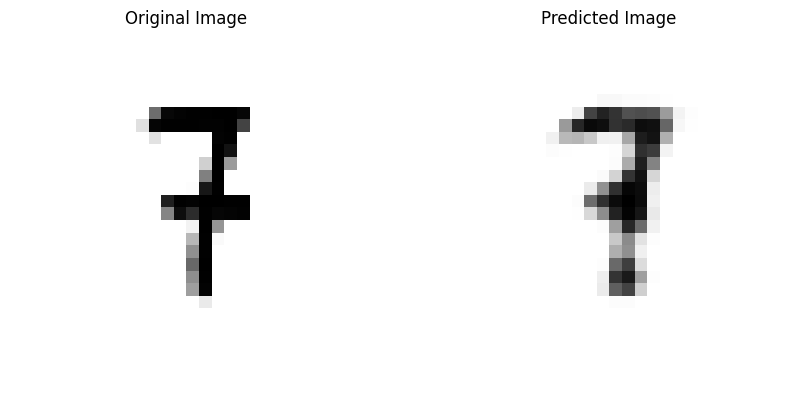

1/1 [==============================] - 0s 16ms/step
Pixel Accuracy for label '8_7297.png': 94.19%


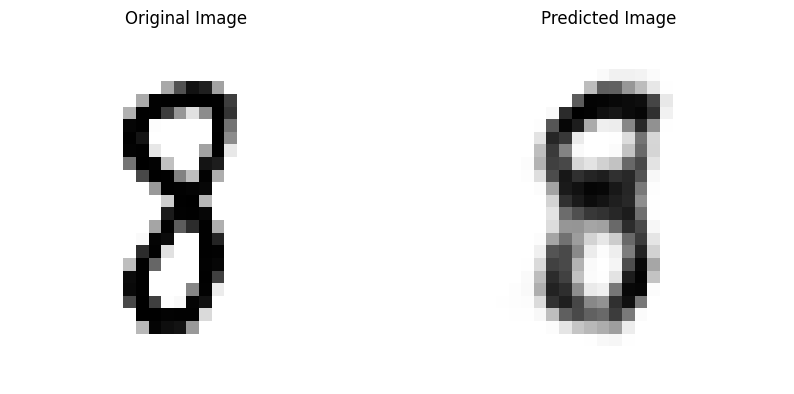

1/1 [==============================] - 0s 14ms/step
Pixel Accuracy for label '5_7842.png': 94.70%


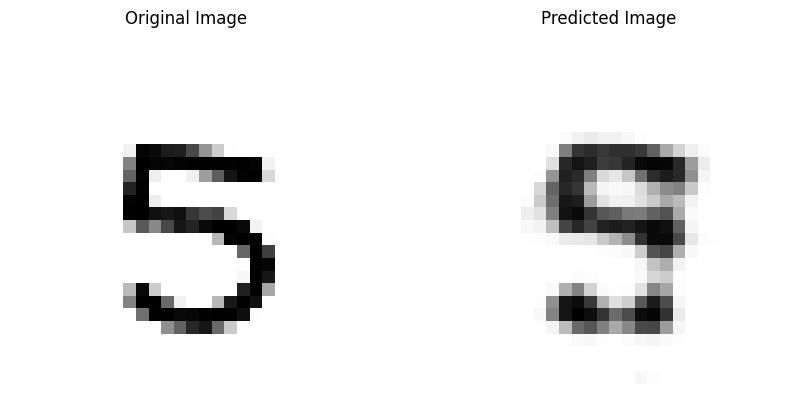

1/1 [==============================] - 0s 15ms/step
Pixel Accuracy for label '1-gray_9896.png': 99.07%


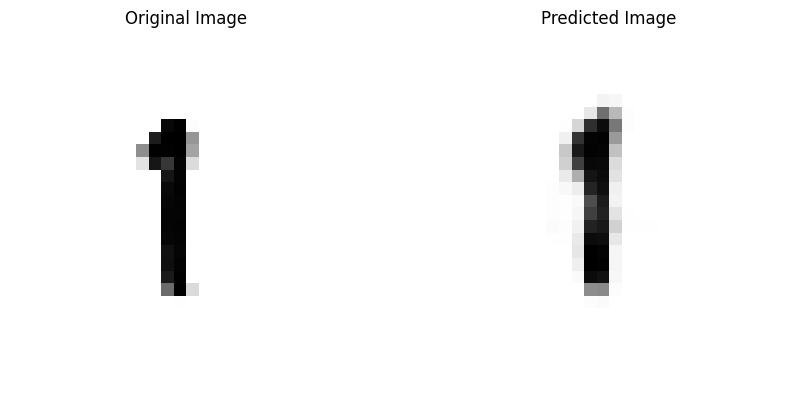

1/1 [==============================] - 0s 15ms/step
Pixel Accuracy for label '1_5713.png': 98.92%


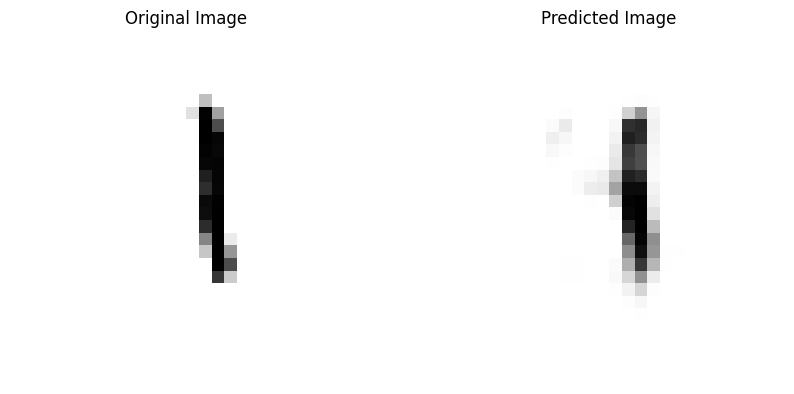

1/1 [==============================] - 0s 15ms/step
Pixel Accuracy for label '6_8897.png': 96.72%


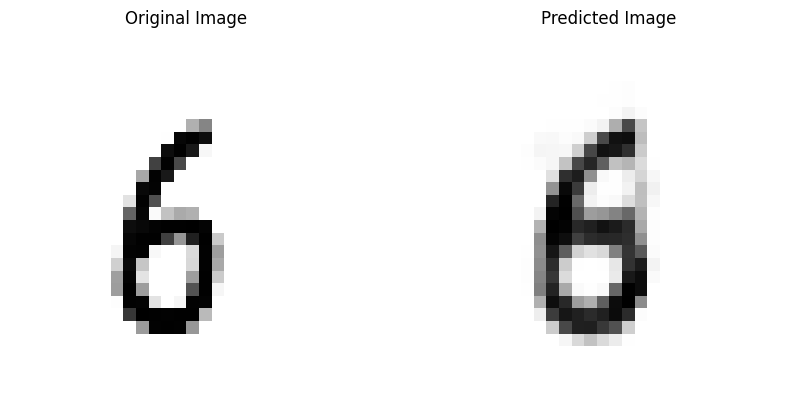

1/1 [==============================] - 0s 14ms/step
Pixel Accuracy for label '9_10554.png': 95.52%


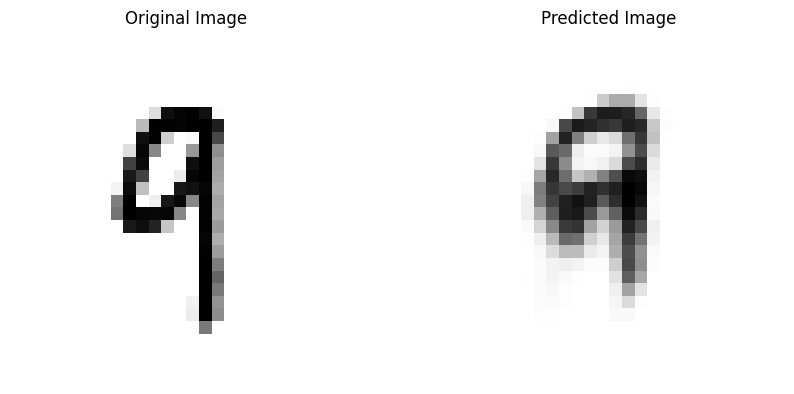

1/1 [==============================] - 0s 15ms/step
Pixel Accuracy for label '6_747.png': 96.74%


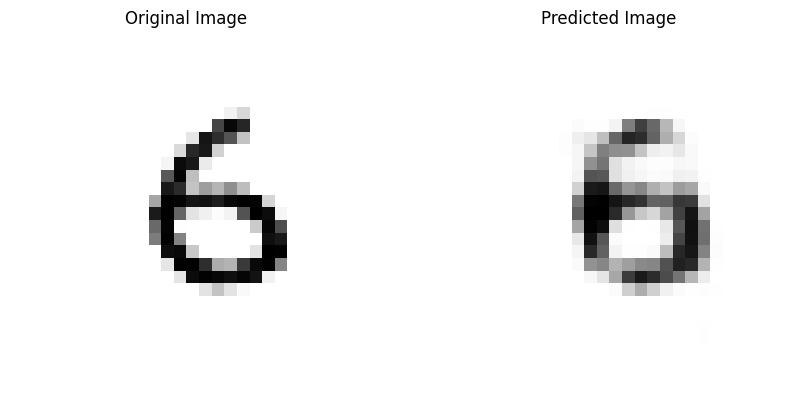

1/1 [==============================] - 0s 16ms/step
Pixel Accuracy for label '4_4866.png': 96.74%


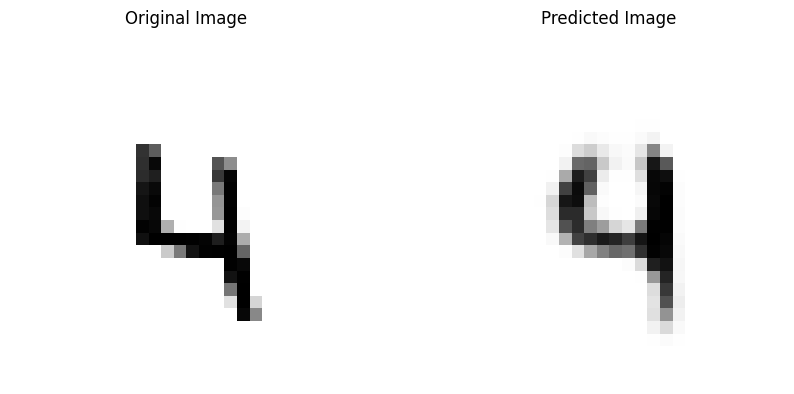


Average Pixel Accuracy over all above images: 96.92%


In [33]:
# List to hold pixel accuracy values for all predictions
all_accuracies = []

# Randomly select 10 labels to predict
labels_to_predict = random.sample(list(df['label'].values), 10)

for label in labels_to_predict:
    # Encode the label as an integer
    encoded_label = np.array([label_encoder.transform([label])[0]]).reshape(1, 1)

    # Make a prediction using the encoded label
    predicted_image = model.predict(encoded_label)

    # Reshape the predicted image and unnormalize it (convert back to 0-255 range)
    predicted_image = predicted_image.reshape((28, 28))
    predicted_image = predicted_image * 255.0  # Unnormalize the predicted image

    # Get the original image from the DataFrame
    original_image = get_original_image_from_df(label, df)

    # Check if the original image is not None
    if original_image is not None:
        # Calculate pixel accuracy
        accuracy = pixel_accuracy(original_image, predicted_image)
        all_accuracies.append(accuracy)
        print(f"Pixel Accuracy for label '{label}': {accuracy:.2f}%")

        # Set up the plot
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')  # Hide axis

        # Plot predicted image
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_image, cmap='gray')
        plt.title('Predicted Image')
        plt.axis('off')  # Hide axis

        plt.show()

# Calculate and print the average pixel accuracy
if all_accuracies:
    average_accuracy = np.mean(all_accuracies)
    print(f"\nAverage Pixel Accuracy over all above images: {average_accuracy:.2f}%")
else:
    print("No valid images found for accuracy calculation.")

In [13]:
# # Function to calculate pixel accuracy by checking if pixels match exactly
# def pixel_accuracy(original, predicted):
#     """
#     Calculate pixel accuracy by comparing if the pixel values are exactly the same.

#     Parameters:
#     original (np.array): The original image array (shape: height x width).
#     predicted (np.array): The predicted image array (shape: height x width).

#     Returns:
#     float: The pixel accuracy as a percentage.
#     """
#     original = np.array(original)
#     predicted = np.array(predicted)
    
#     # Check if the shapes match
#     if original.shape != predicted.shape:
#         raise ValueError("Original and predicted images must have the same shape.")
    
#     # Compare pixel values
#     total_pixels = original.size
#     matching_pixels = np.sum(original == predicted)
    
#     # Calculate accuracy as the percentage of matching pixels
#     accuracy = 100 * (matching_pixels / total_pixels)
    
#     return accuracy  # Return as percentage

# # Function to get the original image data from the DataFrame
# def get_original_image_from_df(label, df):
#     row = df[df['label'] == label]
#     if not row.empty:
#         return row['image_data'].values[0]  # Get the image data
#     else:
#         print("Label not found in DataFrame.")
#         return None

# # List to hold pixel accuracy values for all predictions
# all_accuracies = []

# # Randomly select 10 labels to predict
# labels_to_predict = random.sample(list(df['label'].values), 10)

# for label in labels_to_predict:
#     # Encode the label as an integer
#     encoded_label = np.array([label_encoder.transform([label])[0]]).reshape(1, 1)

#     # Make a prediction using the encoded label
#     predicted_image = model.predict(encoded_label)

#     # Reshape the predicted image and unnormalize it (convert back to 0-255 range)
#     predicted_image = predicted_image.reshape((28, 28))
#     predicted_image = predicted_image * 255.0  # Unnormalize the predicted image

#     # Get the original image from the DataFrame
#     original_image = get_original_image_from_df(label, df)

#     # Check if the original image is not None
#     if original_image is not None:
#         # Calculate pixel accuracy
#         accuracy = pixel_accuracy(original_image, predicted_image)
#         all_accuracies.append(accuracy)
#         print(f"Pixel Accuracy for label '{label}': {accuracy:.2f}%")

#         # Set up the plot
#         plt.figure(figsize=(10, 5))

#         # Plot original image
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image, cmap='gray')
#         plt.title('Original Image')
#         plt.axis('off')  # Hide axis

#         # Plot predicted image
#         plt.subplot(1, 2, 2)
#         plt.imshow(predicted_image, cmap='gray')
#         plt.title('Predicted Image')
#         plt.axis('off')  # Hide axis

#         plt.show()

# # Calculate and print the average pixel accuracy
# if all_accuracies:
#     average_accuracy = np.mean(all_accuracies)
#     print(f"\nAverage Pixel Accuracy over all above images: {average_accuracy:.2f}%")
# else:
#     print("No valid images found for accuracy calculation.")